# Recurrent Neural Networks at character-level
Recurrent Neural Networks (RNNs) are popular models in many NLP tasks such as

* image captioning
* sentiment analysis
* machine translation
* video classification

But what is RNNs? In this notebook, we are going to learn about RNNs by implementing/training a vanilla RNNs to generate text character by character, the notebook covers the following topics

* Brief introduction to RNN and some great resources on RNNs for interested readers
* Detail model architecture with brief discussion on pros/cons of vanilla RNNs
* Implement vanilla RNNs with Numpy
* Implement vanilla RNNs with TensorFlow
$
\newcommand{\real}{\mathbb{R}}
\newcommand{\targets}{\mathrm{targets}}
\newcommand{\argmax}[1]{\mathrm{arg}\max_{#1}}
\newcommand{\mvec}[1]{\pmb{#1}}
$

# Introduction to RNNs
Recall ourselves that we have been looking at [Vanilla Neural Networks](#) and [Convolutional Networks](#), they both share one limitation: 

<center>they accept a fixed-size vector (an image) as input and produce a fixed-size vector as output (scores of different classes). </center>

Why is it limited? It's because in many problems, our inputs/outputs will have variable length e.g

* in text translation the input can be a word or a sequence of words
* in image captioning the output can be a word or a paragraph

This's where RNNs comes in, it allows us to operate over sequences of input and generate a sequences of output. In this notebook we look at the vanilla RNNs which has following diagram

![alt text](./vanilla_rnn_diagram.png "Vanilla RNN diagram")

where 

* $h_0\in \real^H$ is initial hidden state with 
* $x_1,\ldots,x_n\in \real^D$ is a sequence of input 
* $h_1,\ldots,h_n\in \real^H$ is a sequence of hidden states
* $y_1,\ldots,y_n\in \real^C$ is a sequence of output

The vanilla RNNs has following dynamics
$$
\left\{\begin{array}{rl}
h_t &= \tanh\left(W_{xh} \times x_{t} + W_{hh}\times h_{t-1} + b_h\right)\\
y_t &= W_{hy} \times h_t + b_y
\end{array}
\right.
$$

## Model architecture for char-RNNs
In this notebook, we want to use character-wise RNNs, let's look at how we can choose $H, D, C$

* $H$ is a hyper-parameter to control hidden-size so we choose whatever makes RNNs works best (Note that in image-captioning sometime if we can take $h_0$ as output of NNs/CNNs for example *fc7* of AlexNet then $H$ has same size as output of *fc7*)
* $D$ is input size, and we use one-hot encoding for character so $D=$ number of characters e.g if our characters is only English lower case (26 characters) then we have $D=26$ and
$$
\text{"a"} \mapsto \left(\begin{array}{c}1\\
0\\
\vdots\\
0
\end{array}\right)_{26\times 1}
$$
Normally, we will load all the text-data, then get the unique list of our characters and then set $D$ is the size of that unique list (see the implementation for more detail)
* $C$ is output size, in our example we have $C=D$ since the output is also characters. For other application e.g image captioning, $C$ will be the size of vocabulary while $D$ is the size of image input.
* $n$ is the length of input sequence, in this notebook we use $n=25$.

To understand better the forward pass of RNNs, we look at example from [Karpathy](http://karpathy.github.io/2015/05/21/rnn-effectiveness/)
<img src="./charseq.jpeg" alt="hello example" style="width: 500px;"/>

In above example, the RNNs takes input sequences "h", "e", "l", "l" and it wants to compute scores output sequence, the target sequence is "e", "l", "l", "o". 

More generally, we will feed the RNN a huge chunk of text and ask it to train $W_{xh}, W_{hh}, b_h, W_{hy}, b_{y}$ so it can model the probability distribution of the next character given a sequence of previous characters i.e
* given input-sequence $x_1,\ldots,x_n$ 
* and target-sequence $\targets_1,\ldots\targets_n$
* RNNs forward pass gives us $y_1,\ldots,y_n$ which allows us to models the distribution $p_t$ of output sequence  using following form
$$
p_t[c] = p(\targets_t = c) = \frac{\exp(y_t[c])}{\sum_{c=1}^{26}\exp(y_t[c])}
$$
$p_t$ is the probability distribution over character at $t-th$ position of output sequence. Note here, given a trained model, we can use $p_t$ to predicts the character at time $t$ as such 
$$c_t = \argmax{c}p_t[c]$$

In order to train $W_{xh}, W_{hh}, b_h, W_{hy}, b_{y}$, we need to define an objective function (cost function), and here we use the **Softmax** loss function (also commonly referred to as the cross-entropy loss)
$$
L_t(y_t, \targets_t) = - \log\left(p_t[\targets_t]\right)
$$
Intuitively, by minimizing loss function, it's equivalent to maximize the chance $p_t[\targets_t]$ close to 1.0 (in other word it predicts correct next character).

## RNNs resources
We have done a brief introduction on RNNs (quite a long one), for anyone interested in knowing more about RNNs and LSTMs please check out few great blog posts
1. [The Unreasonable Effectiveness of Recurrent Neural Networks](http://karpathy.github.io/2015/05/21/rnn-effectiveness/), by Andrej Karpathy
2. [Understanding LSTM Networks](http://colah.github.io/posts/2015-08-Understanding-LSTMs/), by Christopher Olah

Let's do some implementation on character-wise RNNs

# Implementing character-wise RNN (char-RNN)
First let import some python module that we use though this notebook

In [1]:
import time
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from collections import namedtuple

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

# Preparing training data
We will train our char-RNN on Anna Karenina (anna.txt), we need to load our data into memory to get the character-sizes ($D$ and $C$)

In [2]:
text = None
with open('anna.txt', 'r') as f:
    text = f.read()

# build set of all characters
ch_set = set(text)
ch_size = len(ch_set)
print('our input has %d unique characters' % ch_size)

# helper dictionary to map char -> index and inversely
ch_to_int = {c:i for i,c in enumerate(ch_set)}
int_to_ch = dict(enumerate(ch_set))

# convert text to numerics input data
datas = np.array([ch_to_int[c] for c in text], dtype = np.int32)

our input has 83 unique characters


In [3]:
text[:100]

'Chapter 1\n\n\nHappy families are all alike; every unhappy family is unhappy in its own\nway.\n\nEverythin'

In [4]:
datas[:100]

array([35, 18, 72, 61, 19, 52, 49, 60, 39, 44, 44, 44,  6, 72, 61, 61, 31,
       60, 66, 72, 65, 50, 62, 50, 52, 58, 60, 72, 49, 52, 60, 72, 62, 62,
       60, 72, 62, 50, 33, 52,  0, 60, 52, 16, 52, 49, 31, 60, 32, 81, 18,
       72, 61, 61, 31, 60, 66, 72, 65, 50, 62, 31, 60, 50, 58, 60, 32, 81,
       18, 72, 61, 61, 31, 60, 50, 81, 60, 50, 19, 58, 60, 40, 71, 81, 44,
       71, 72, 31, 82, 44, 44, 55, 16, 52, 49, 31, 19, 18, 50, 81], dtype=int32)

We need to split up data into batches and into training & validation sets (using the split_frac argument). We are not making a test set here, instead we will test if our model can generate new text (that makes some sense).

We use the 2D-matrix to store input-data and target-data where 

* each row is a long concatenated string from the character data
* the number of rows is equal to the batch_size (number of sample in each batch)

The idea is given **matrix_data**, to get a batch of samples of *seq_len*, we can have a sliding windows 
$$\mathrm{matrix\_data}[:, p:p+seq\_len]$$
which gives batch_size rows and each row is a sequence has seq_len characters.

In [3]:
def split_data(datas, batch_size, seq_len, split_frac = 0.9):
    '''
    Split datas into training and validation sets, inputs & targets for each set.
    
    Arguments
    ------------------------
    datas : character input (in numerics format)
    batch_size: size of each batch
    seq_len: length of each sequence
    split_frac: fraction of batches to keep in the training set
    
    Returns train_x, train_y, val_x, val_y
    '''
    # get size of each batch & number of batches
    slice_size = batch_size * seq_len
    n_batches = len(datas) // slice_size
    
    # put data into x & y, note here y is x shifted to the right one
    x = datas[:n_batches * slice_size]
    y = datas[1: 1 + n_batches * slice_size]
    
    # split x & y to batch_size slices, then stack them into 2D matrix => each row is a sequence input
    x = np.stack(np.split(x, batch_size))
    y = np.stack(np.split(y, batch_size))
    
    # split into training and validation sets
    split_idx = int(n_batches * split_frac)
    train_x, train_y = x[:, : split_idx * seq_len], y[:, : split_idx * seq_len]
    val_x, val_y = x[:, split_idx * seq_len :], y[:, split_idx * seq_len :]
    
    return train_x, train_y, val_x, val_y
    
batch_size = 50
seq_len = 25
train_x, train_y, val_x, val_y = split_data(datas, batch_size, seq_len)

print (train_x.shape)
print (val_x.shape)

(50, 35725)
(50, 3975)


## Forward pass
Let first implement the forward pass 

* denote $\vec{x}=(x_1,\ldots,x_n)$ the input-sequence
* denote $\vec{\targets} = (\targets_1,\ldots,\targets_n)$ the target-sequence
* given $W_{xh}, W_{hh}, b_h, W_{hy}, b_y$,and initial hidden state $h_0$, 

we want to compute the scores output
$$
\vec{y} = (y_1, \ldots, y_n) 
$$
and the Softmax loss
$$
L(\vec{y},\vec{\targets}) = \sum_{t} L_t(y_t, \targets_t)
$$

In [6]:
def rnn_forward_one_sample(x, targets, h_prev, params):
    '''
    Implements the forward pass for rnn
    
    Arguments
    ------------------------------
        x: input data
        targets: input targets
        h_prev: hidden state at t=0
        params: a tuple of model parameters (Wxh, Whh, Why, bh, by)
    Returns 
        loss: the softmax loss
        cache: the cache to be used in backward pass
    '''
    seq_len = len(x)
    Wxh, Whh, Why, bh, by = params
    
    # convert input to one-hot encoding
    xs, hs, ys, ps = {}, {}, {}, {}
    
    # previous hidden state
    hs[-1] = np.copy(h_prev)
    
    loss = 0.0
    for t in range(seq_len):
        # one-hot xs
        xs[t] = np.zeros((ch_size, 1))
        xs[t][x[t]] = 1.0
        
        # update hidden state
        hs[t] = np.tanh(Wxh.dot(xs[t]) + Whh.dot(hs[t-1]) + bh)
        
        # update scores & probab
        ys[t] = Why.dot(hs[t]) + by
        tmp = np.exp(ys[t])
        ps[t] = tmp/np.sum(tmp)
        tmp = -np.log(ps[t][targets[t], 0])        
        loss += tmp

    cache = (xs, hs, ps, targets)
    return loss, cache

In [7]:
hidden_size = 128
h0 = np.zeros((hidden_size, 1))
Wxh = np.random.randn(hidden_size, ch_size) * 1e-3
Whh = np.random.randn(hidden_size, hidden_size) * 1e-3
Why = np.random.randn(ch_size, hidden_size) * 1e-3
bh = np.zeros((hidden_size,1))
by = np.zeros((ch_size,1))
params = (Wxh, Whh, Why, bh, by)

In [8]:
test_len = 3
loss, cache = rnn_forward_one_sample(train_x[0,0:test_len], train_y[0, 0: test_len], h0, params)
print (loss)

13.2564973924


## Backward propagation
Note that the loss function is
$$
L = \sum_t{L_t(y_t,\targets_t)}
$$
So first we need to compute
$$
\nabla_{y_t}L_t(y_t,\targets_t)
$$
Recall from previous notebook on [Softmax loss](https://minh84.github.io/ml-examples/demos/learn_tf/02-linear-classifier-softmax/), we have
$$
\nabla_{y_t}L_t(y_t,\targets_t) = p_t - \mathrm{eye}[\targets_t]
$$
where $\mathrm{eye}[\targets_t]$ is $\targets_t$-th row of the identity matrix (note here we use [np.eye](https://docs.scipy.org/doc/numpy/reference/generated/numpy.eye.html).

Next backward-propagation from scores $y_t$ to hidden-state $h_t$, note that 
$$
y_t = W_{hy} h_t + b_y
$$
which is a linear function, so we can derive the backward derivative on $h_t, W_{hy}, b_y$ as
\begin{align*}
\nabla_{h_t}L_t &= (W_{hy})^T \times \nabla_{y_t}L_t(y_t,\targets_t)\\
\nabla_{W_{hy}}L_t &= \nabla_{y_t}L_t(y_t,\targets_t) \times \left(h_t\right)^T\\
\nabla_{b}L_t &= \nabla_{y_t}L_t(y_t,\targets_t)
\end{align*}
Note here since we share $W_{hy}, b_y$ accross $t$ the derivative on these term need to be added up.

Now look at the hidden-state, since we have
$$
h_t = \tanh(W_{xh} \times x_t + W_{hh} \times h_{t-1} + b_h)
$$
and $\frac{\partial \tanh(x)}{\partial x} = 1 - \left(\tanh(x)\right)^2$

Then given $\nabla_{h_t}L_t$, we derive the following gradient
\begin{align*}
\nabla_{h_{t-1}}L_t &= (1.0 - h_t^2) \odot \left(W_{hh}\right)^T\times \nabla_{h_t}L_t\\
\nabla_{W_{xh}}L_t &= (1.0 - h_t^2) \odot \nabla_{h_t}L_t \times (x_t)^T\\
\nabla_{W_{hh}}L_t &= (1.0 - h_t^2) \odot \nabla_{h_t}L_t \times (h_{t-1})^T\\
\nabla_{b_{h}}L_t &= (1.0 - h_t^2) \odot \nabla_{h_t}L_t
\end{align*}
Note here we need actually compute
$$
\nabla_{h_t} \sum_{t}L_t
$$
And we notice that in forward pass $h_t$ only affect $L_k$ for $k\geq t$, so at each time step $t$ we have two term
$$
\nabla_{h_t} \sum_{t}L_t = \nabla_{h_t} L_t + \nabla_{h_t} \sum_{k>t}L_k
$$
And the second term has following recursive form
$$
\nabla_{h_t} \sum_{k>t}L_k = \left\{
\begin{array}{cl}
0 & \text{if } t=n\\
(1.0 - h_{t+1}^2) \odot \left(W_{hh}\right)^T\times \left(\nabla_{h_{t+1}}L_{t+1} + \nabla_{h_{t+1}} \sum_{k>t+1}L_k\right) & \text{otherwise i.e } t < n
\end{array}
\right.
$$
We will see in the code below
\begin{align*}
\nabla_{h_t} \sum_{k>t}L_k &= \textit{dhnext}\\
\nabla_{h_t} L_t &= \textit{np.dot(Why.T, dy)}\\
\nabla_{h_t} L &= \textit{np.dot(Why.T, dy) + dhnext}
\end{align*}


In [9]:
def rnn_backward_one_sample(cache, params):
    '''
    Implement the backward propagation for rnn
    
    Arguments
    ----------------------
        cache = (xs, hs, ps, targets) 
        params = (Wxh, Whh, Why, bh, by)
    
    Return 
        dWxh, dWhh, dWhy, dbh, dby
    '''
    xs, hs, ps, targets = cache
    seq_len = len(xs)
    dhnext = np.zeros_like(hs[0])
    Wxh, Whh, Why, bh, by = params
    
    dWxh = np.zeros_like(Wxh)
    dWhh = np.zeros_like(Whh)
    dWhy = np.zeros_like(Why)
    dbh  = np.zeros_like(bh)
    dby  = np.zeros_like(by)
    dhs = []
    for t in reversed(range(seq_len)):
        dy = np.copy(ps[t])
        dy[targets[t]] -= 1 # backward to y see above formula
        
        # backward to W_hy & b_y and some accross t
        dWhy += np.dot(dy, hs[t].T)
        dby += dy
        
        # backward to dy_t(L_t) -> dh_t (L_t) + the one from \sum_{k>t}L_k
        dh = np.dot(Why.T, dy) + dhnext
        
        dhs.append(dhnext)
        
        # backward tanh
        dhraw = (1.0 - hs[t] * hs[t]) * dh
        
        # backward to bh, Wxh, Whh
        dbh  += dhraw
        dWxh += np.dot(dhraw, xs[t].T)
        dWhh += np.dot(dhraw, hs[t-1].T)
        
        # propagate dhnext for dh_{t-1}(\sum_{k>=t}L_k)
        dhnext = np.dot(Whh.T, dhraw)
    return dWxh, dWhh, dWhy, dbh, dby, np.array(dhs)

def loss_rnn_one_sample(x, targets, h_prev, params):
    '''
    Implement one forward-pass compute the loss and one backward-pass to compute gradient
    
    Arguments
    --------------------
        x: input sequence
        targets: target sequence
        h_prev: previous hidden state
        params: a tuple of (Wxh, Whh, Why, bh, by)
    
    Return
        loss, dWxh, dWhh, dWhy, dbh, dby and hidden-state for next sequence
    '''
    seq_len = len(x)
    loss, cache = rnn_forward_one_sample(x, targets, h_prev, params)
    dWxh, dWhh, dWhy, dbh, dby, dhs = rnn_backward_one_sample(cache, params)
    hs = cache[1]
    return loss, dWxh, dWhh, dWhy, dbh, dby, hs[seq_len - 1], dhs[-1]

## Numerical testing
It's always go idea to test our implementation via numerical gradient

In [34]:
# we reduce number of hidden_size so that we can test it quicker
hidden_size = 10
test_len = 3

h0 = np.zeros((hidden_size, 1))
Wxh = np.random.randn(hidden_size, ch_size) 
Whh = np.random.randn(hidden_size, hidden_size)
Why = np.random.randn(ch_size, hidden_size)
bh = np.zeros((hidden_size,1))
by = np.zeros((ch_size,1))

In [35]:
from gradient_check import grad_check_sparse, eval_numerical_gradient, rel_error

params = (Wxh, Whh, Why, bh, by)

x, targets = train_x[0,0:test_len], train_y[0, 0: test_len]
loss, dWxh, dWhh, dWhy, dbh, dby, hnext,_ = loss_rnn_one_sample(x, targets, h0, params)

f = lambda wxh : loss_rnn_one_sample(x, targets, h0, (wxh, Whh, Why, bh, by))[0]
grad_Wxh = eval_numerical_gradient(f, Wxh, verbose = False)

f = lambda whh : loss_rnn_one_sample(x, targets, h0, (Wxh, whh, Why, bh, by))[0]
grad_Whh = eval_numerical_gradient(f, Whh, verbose = False)

f = lambda why : loss_rnn_one_sample(x, targets, h0, (Wxh, Whh, why, bh, by))[0]
grad_Why = eval_numerical_gradient(f, Why, verbose = False)

f = lambda b_h : loss_rnn_one_sample(x, targets, h0, (Wxh, Whh, Why, b_h, by))[0]
grad_bh = eval_numerical_gradient(f, bh, verbose = False)

f = lambda b_y : loss_rnn_one_sample(x, targets, h0, (Wxh, Whh, Why, bh, b_y))[0]
grad_by = eval_numerical_gradient(f, by, verbose = False)

print ('Loss: {:10.5f}'.format(loss))
print('Rel error dWxh: {:10.5e}'.format(rel_error(dWxh, grad_Wxh)))
print('Rel error dWhh: {:10.5e}'.format(rel_error(dWhh, grad_Whh)))
print('Rel error dWhy: {:10.5e}'.format(rel_error(dWhy, grad_Why)))
print('Rel error dbh:  {:10.5e}'.format(rel_error(dbh, grad_bh)))
print('Rel error dby:  {:10.5e}'.format(rel_error(dby, grad_by)))

Loss:   31.98509
Rel error dWxh: 1.19144e-06
Rel error dWhh: 5.05316e-08
Rel error dWhy: 3.42830e-05
Rel error dbh:  3.11615e-10
Rel error dby:  5.52779e-06


The results look correct, to double-check it, now let's try to implement char-RNN in TensorFlows. Also TensorFlows allows us to extend RNN very well.

## Vanilla char-RNN with TensorFlow
In this part we will learn how to

* Use one-hot encoding in TensorFlow with [tf.one_hot](https://www.tensorflow.org/api_docs/python/tf/one_hot)
* Split/concat array data with [tf.split](https://www.tensorflow.org/api_docs/python/tf/split)/[tf.concat](https://www.tensorflow.org/api_docs/python/tf/concat)
* Implement rnn forward/backward for one sample in TensorFlows, then look at two issue with vanilla-RNN
    * Gradient exploding
    * Gradient vanishing
* Implement rnn with mini-batches using [tf.contrib.rnn.BasicRNNCell](https://www.tensorflow.org/api_docs/python/tf/contrib/rnn/BasicRNNCell)

In [36]:
# reset default graph
tf.reset_default_graph()

seq_len = test_len

# define input placeholder and tensor h0
vx = tf.placeholder(tf.int32, [seq_len], name = 'input')
vy = tf.placeholder(tf.int32, [seq_len], name = 'target')
vh0 = tf.zeros([hidden_size, 1], dtype=tf.float64)

# one hot encoding
vx_one_hot = tf.one_hot(vx, ch_size, dtype=tf.float64)

# define basic rnn
cell = tf.contrib.rnn.BasicRNNCell(hidden_size)

### Run the data through the RNN layers
# This makes a list where each element is on step in the sequence
rnn_inputs = tf.split(vx_one_hot, seq_len, axis=0)

with tf.variable_scope('hidden'):
    vWxh = tf.Variable(Wxh, name = 'Wxh', dtype=tf.float64)
    vWhh = tf.Variable(Whh, name = 'Whh', dtype=tf.float64)
    vbh = tf.Variable(bh, name = 'bh', dtype=tf.float64)    

with tf.variable_scope('softmax'):
    vWhy = tf.Variable(Why, name = 'Why', dtype=tf.float64)
    vby = tf.Variable(by, name = 'by', dtype=tf.float64)

vhs_t = vh0    
ys = []
for t, xs_t in enumerate(rnn_inputs):
    # we need transpose xs_t since TensorFlow takes vector-input by row, here we want column with shape (ch_size, 1)
    vhs_t = tf.tanh(tf.matmul(vWxh, tf.transpose(xs_t)) + tf.matmul(vWhh, vhs_t) + vbh)
    
    # the form is exactly as in numpy's implementation
    ys_t = tf.matmul(vWhy, vhs_t) + vby    
    ys.append(ys_t)

# we need to stack (ys_t)^T in each row so that we can use tf.nn.sparse_softmax_cross_entropy_with_logits
output = tf.transpose(tf.concat(ys,axis=1))

# get the Softmax and gradient
cost = tf.reduce_sum(tf.nn.sparse_softmax_cross_entropy_with_logits(logits = output, labels=vy))
grad = tf.gradients(cost, [vWxh, vWhh, vWhy, vbh, vby])

# run test
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())    
    loss_tf, grad_tf = sess.run([cost, grad], feed_dict = {vx : x, vy : targets})   
    print ('loss: ', loss_tf)
    print('Rel error loss: {:10.5e}'.format(rel_error(loss, loss_tf)))
    print('Rel error dWxh: {:10.5e}'.format(rel_error(dWxh, grad_tf[0])))
    print('Rel error dWxh: {:10.5e}'.format(rel_error(dWhh, grad_tf[1])))
    print('Rel error dWxh: {:10.5e}'.format(rel_error(dWhy, grad_tf[2])))
    print('Rel error dWxh: {:10.5e}'.format(rel_error(dbh, grad_tf[3])))
    print('Rel error dWxh: {:10.5e}'.format(rel_error(dby, grad_tf[4])))

loss:  31.9850876069
Rel error loss: 0.00000e+00
Rel error dWxh: 1.05926e-12
Rel error dWxh: 3.94742e-14
Rel error dWxh: 9.02872e-14
Rel error dWxh: 4.93427e-16
Rel error dWxh: 8.92087e-16


For single sample, we can see that the results obtained by TensorFlow are very close to result obtained by numpy as expected.

Now let's look at two issues with Vanilla-RNN

* Gradient exploding
* Gradient vanishing

In [30]:
test_hidden_size = 3

h0 = np.zeros((test_hidden_size, 1))
test_Wxh = np.zeros((test_hidden_size, ch_size))
test_Wxh[range(test_hidden_size), range(test_hidden_size)] = 1.0
test_Why = np.zeros((ch_size, test_hidden_size))
test_Why[range(test_hidden_size), range(test_hidden_size)] = 1.0

test_bh = np.zeros((test_hidden_size,1))
test_by = np.zeros((ch_size,1))


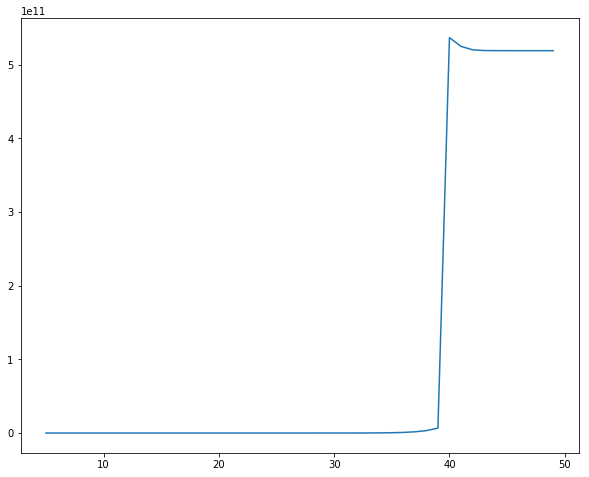

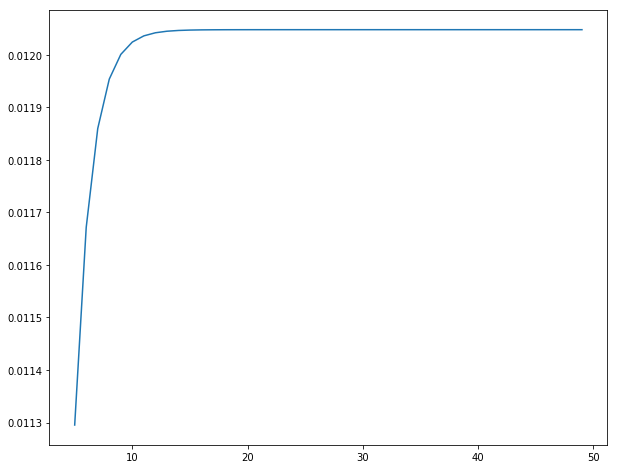

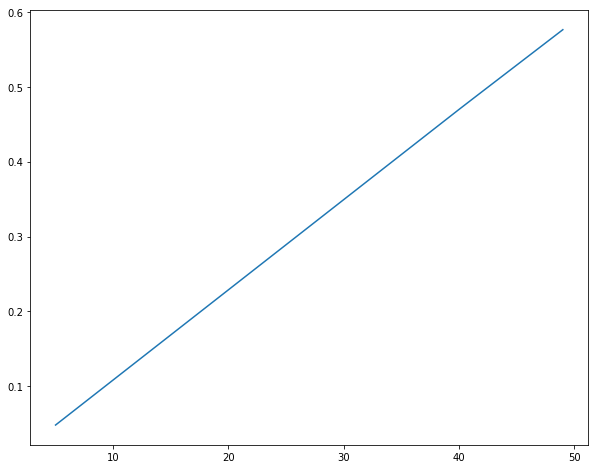

In [31]:
test_Whh = np.diag([2., 0.5, 1.0])
test_params = (test_Wxh, test_Whh, test_Why, test_bh,test_by)
test_lens = []
dhs0 = []
dhs1 = []
dhs2 = []
for sl in range(5,50):
    test_lens.append(sl)
    test_x, test_targets = train_x[0,0:sl], train_y[0, 0: sl]
    loss, dWxh, dWhh, dWhy, dbh, dby, hnext, dhs = loss_rnn_one_sample(test_x, test_targets, h0, test_params)
    dhs0.append(np.abs(dhs[0]))
    dhs1.append(np.abs(dhs[1]))
    dhs2.append(np.abs(dhs[2]))

plt.plot(test_lens, dhs0)
plt.show()
plt.plot(test_lens, dhs1)
plt.show()
plt.plot(test_lens, dhs2)

In the above, we vary the length of input sequence and draw the gradient with respect to $h_0$. We set $W_hh$ is a diagonal matrix with first eigenvalue > 1.0, the second < 1.0 and the third = 1.0

From the plot, we see 
* gradient for $h_0[0]$ explode with respect to sequence-length => exploding Gradient
* gradient for $h_0[1]$ become constant with respect to sequence-length => vanishing Gradient
* gradient for $h_0[2]$ is normal since we set the third eigen-value = 1.0

One can use gradient clipping to control exploding and LSTM to cure vanishing Gradient (in this note we only discuss RNN). 

## Mini-batches for Vanilla char-RNN with TensorFlow
Let's implement gradient-clipping with TensorFlow and we will also implement mini-batches version instead of single input. Before doing the mini-batches version we need re-define the shape of our data

* input_data: has shape (batch_size, seq_len) with each point is an int32
* target_data: has same format as input_data

At each time step $t$, instead of computing single hidden-state $h_t$ & single score $y_t$, we will update a vector of batch_size $h_t$ and $y_t$. We will learn how to

* use [tf.squeeze](https://www.tensorflow.org/api_docs/python/tf/squeeze) to remove dimension of size 1, so that we can use matrix multiplication
* use [tf.contrib.rnn.BasicRNNCell](https://www.tensorflow.org/api_docs/python/tf/contrib/rnn/BasicRNNCell)


In [4]:
def mini_batch_rnn(ch_size, batch_size = 50, seq_len = 25, hidden_size = 128, 
                   use_lstm = False, use_dropout = False, num_layers = 1,
                   lr = 1e-3, grad_clip = 5.0, dtype = tf.float32):
    '''
    This implement mini-batch version for rnn
    
    Arguments
    ---------------------
        ch_size: size of all character in our training set
        batch_size: number of input sequence per batch
        seq_len: len of input sequence
        hidden_size: size of hidden-state
        lr: learning rate for optimizer
        grad_clip: to clip the gradient to control exploding gradient
    '''
    # reset the graph
    tf.reset_default_graph()
    
    # create placeholders
    inputs = tf.placeholder(tf.int32, [batch_size, seq_len], name = 'inputs')
    targets = tf.placeholder(tf.int32, [batch_size, seq_len], name = 'targets')    
    
    # Keep probability placeholder for drop out layers
    keep_prob = tf.placeholder(dtype=dtype, name='keep_prob')
    
    # one-hot encoding
    inputs_one_hot = tf.one_hot(inputs, ch_size, dtype = dtype) # this has shape (batch_size, seq_len, ch_size)
    
    # create rnn_inputs
    # rnn_inputs[t] is inputs[:, t] in one-hot encoding
    rnn_inputs = [tf.squeeze(i, axis=[1]) for i in tf.split(inputs_one_hot, seq_len, axis=1)]
    
    # create RNN layer + dropout
    if use_lstm:
        cell = tf.contrib.rnn.BasicLSTMCell(hidden_size)
    else:
        cell = tf.contrib.rnn.BasicRNNCell(hidden_size)
    if use_dropout:
        cell = tf.contrib.rnn.DropoutWrapper(cell, output_keep_prob=keep_prob)
        
    # stack up multiple RNN layers + get initial_state
    if num_layers > 1:
        cell = tf.contrib.rnn.MultiRNNCell([cell] * num_layers)
    initial_state = cell.zero_state(batch_size, dtype)
    
    # compute h_t update via static_rnn: outputs is [h_t, t=1,...,n], final_state = h_n
    outputs, final_state = tf.contrib.rnn.static_rnn(cell, rnn_inputs, initial_state=initial_state)
        
    # each outputs is h_t of size (batch_size, hidden_size) and len(outputs) = seq_len
    # we concatenate by axis=1 so row i-th is stack h_1[i],...,h_n[i]
    seq_output = tf.concat(outputs, axis=1)            # this has shape (batch_size, hidden_size * seq_len)
    
    # reshape so we can use matmul to produce y_t
    output = tf.reshape(seq_output, [-1, hidden_size]) 
    
    # create Why & by
    with tf.variable_scope('softmax'):
        vWhy = tf.Variable(tf.truncated_normal((hidden_size, ch_size), stddev=0.1, dtype = dtype), name = 'Why')
        vby = tf.Variable(tf.zeros(ch_size, dtype = dtype), name = 'by', dtype = dtype)
    
    # compute y_t
    logits = tf.matmul(output, vWhy) + vby
    preds = tf.nn.softmax(logits, name='predictions')
    
    # reshape target so we can use Softmax loss
    targets_reshaped = tf.reshape(targets, [-1])
    cost = tf.reduce_sum(tf.nn.sparse_softmax_cross_entropy_with_logits(logits = logits, 
                                                                        labels = targets_reshaped))
    
    # we get trainable variables and clipped-gradients
    tvars = tf.trainable_variables()
    grads_raw = tf.gradients(cost, tvars)
    grads, _ = tf.clip_by_global_norm(grads_raw, grad_clip)
    
    # we use AdamOptimizer so that learning_rate can be auto-ajust
    train_op = tf.train.AdamOptimizer(learning_rate=lr)
    
    # we apply the gradient onto trainable variables note that we have already clipped gradients
    optimizer = train_op.apply_gradients(zip(grads, tvars))
    
    # export the nodes
    export_nodes = ['inputs', 'targets', 'keep_prob', 'initial_state', 'grads_raw', 'final_state', 'cost', 'preds', 'optimizer']
    local_dict = locals()
    
    # use namedtuple to export nodes
    VanillaRRN = namedtuple('VanillaRNN', export_nodes)
    model = VanillaRRN(*[local_dict[node] for node in export_nodes])
    
    return model

## Testing our model
Since we have well tested base-model, it's always good idea to check our implementation v.s base-one. Note that in 
*BasicRNNCell*, the weights $W_{xh}$ and $W_{hh}$ are stacked together. The code below is a bit ugly since we have to hack the the initilization steps, but it works 

In [38]:
model = mini_batch_rnn(ch_size, batch_size=1, seq_len = 3, hidden_size=10, dtype = tf.float64)

wxh_test = np.hstack([Wxh, Whh]).transpose()
btest = bh.reshape(hidden_size,)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for v in tf.trainable_variables():        
        if (v.name == 'rnn/basic_rnn_cell/weights:0'):
            _ = sess.run(tf.assign(v, wxh_test))
        if (v.name == 'rnn/basic_rnn_cell/biases:0'):
            _ = sess.run(tf.assign(v, btest))
        
        if (v.name == 'softmax/Why:0'):
            _ = sess.run(tf.assign(v, Why.transpose()))
            
        if (v.name == 'softmax/by:0'):
            _ = sess.run(tf.assign(v, by.reshape(ch_size,)))
    
    loss_rnn, grads_raw = sess.run([model.cost, model.grads_raw], 
                                   feed_dict = {model.inputs: x.reshape(1,3),
                                                model.targets: targets.reshape(1,3),
                                                model.keep_prob : 1.0})
    print (loss_rnn)
    
    print('Rel error loss: {:10.5e}'.format(rel_error(loss, loss_rnn)))
    print('Rel error dWxh: {:10.5e}'.format(rel_error(np.hstack([dWxh, dWhh]).transpose(), grads_raw[0])))    
    print('Rel error dWxh: {:10.5e}'.format(rel_error(dbh.reshape(hidden_size,), grads_raw[1])))
    print('Rel error dWxh: {:10.5e}'.format(rel_error(dWhy.transpose(), grads_raw[2])))
    
    print('Rel error dby:  {:10.5e}'.format(rel_error(dby.reshape(ch_size,), grads_raw[3])))
    

31.9850876069
Rel error loss: 0.00000e+00
Rel error dWxh: 1.05920e-12
Rel error dWxh: 1.48028e-15
Rel error dWxh: 3.55016e-14
Rel error dby:  7.68366e-16


The relative errors are quite small, we are confident that it works as expected. Let's train our model

## Training time
Each time-step, we feed our model as mini-batch of data. It will update training variables and return a state back (*final_state*) in to the network so the next batch can continue the state from the previous batch. Note that, we have to

* At each epoch, we have to reset initial_state back to 0.0
* At each time we valuate on validation set, we have to reset initial_state back to 0.0

We also save down a checkpoint so that we can re-use later, we use the following naming convention (taken from [Udacity](https://www.udacity.com/))

In [5]:
batch_size = 50
seq_len = 25
hidden_size = 128
num_layers = 2
keep_prob = 0.5
learning_rate = 1e-3

def get_batch(arrs, seq_len):
    batch_size, slice_size = arrs[0].shape
    
    n_batches = int(slice_size/seq_len)
    for b in range(n_batches):
        yield [x[:, b*seq_len: (b+1)*seq_len] for x in arrs]

In [6]:
model = mini_batch_rnn(ch_size, batch_size=batch_size, 
                       seq_len = seq_len, hidden_size=hidden_size, 
                       use_lstm = True, use_dropout=True, num_layers = 1, 
                       lr = learning_rate)
saver = tf.train.Saver(max_to_keep=100)

epochs = 20
save_every_n = 500
print_every = 100
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    # Use the line below to load a checkpoint and resume training
    #saver.restore(sess, 'checkpoints/______.ckpt')
    
    n_batches = int(train_x.shape[1]/seq_len)
    iterations = n_batches * epochs
    for e in range(epochs):
        # Train network
        new_state = sess.run(model.initial_state)
        loss = 0
        for b, (x, y) in enumerate(get_batch([train_x, train_y], seq_len), 1):
            iteration = e*n_batches + b
            start = time.time()
            feed = {model.inputs: x,
                    model.targets: y,
                    model.keep_prob: keep_prob,
                    model.initial_state: new_state}
            batch_loss, new_state, _ = sess.run([model.cost, model.final_state, model.optimizer], 
                                                 feed_dict=feed)
            loss += batch_loss
            end = time.time()
            if (iteration % print_every == 0):
                print('Epoch {}/{} '.format(e+1, epochs),
                      'Iteration {}/{}'.format(iteration, iterations),
                      'Training loss: {:.4f}'.format(loss/b),
                      '{:.4f} sec/batch'.format((end-start)))
        
            
            if (iteration%save_every_n == 0) or (iteration == iterations):
                # Check performance, notice dropout has been set to 1
                val_loss = []
                new_state = sess.run(model.initial_state)
                for x, y in get_batch([val_x, val_y], seq_len):
                    feed = {model.inputs: x,
                            model.targets: y,
                            model.keep_prob: 1.,
                            model.initial_state: new_state}
                    batch_loss, new_state = sess.run([model.cost, model.final_state], feed_dict=feed)
                    val_loss.append(batch_loss)

                print('Validation loss:', np.mean(val_loss),
                      'Saving checkpoint!')
                saver.save(sess, "./checkpoints/i{}_l{}_v{:.3f}.ckpt".format(iteration, hidden_size, np.mean(val_loss)))

Epoch 1/20  Iteration 100/28580 Training loss: 4136.5017 0.0126 sec/batch
Epoch 1/20  Iteration 200/28580 Training loss: 3910.3344 0.0118 sec/batch
Epoch 1/20  Iteration 300/28580 Training loss: 3731.1911 0.0140 sec/batch
Epoch 1/20  Iteration 400/28580 Training loss: 3598.1606 0.0127 sec/batch
Epoch 1/20  Iteration 500/28580 Training loss: 3496.4278 0.0185 sec/batch
Validation loss: 2980.15 Saving checkpoint!
Epoch 1/20  Iteration 600/28580 Training loss: 3417.7046 0.0151 sec/batch
Epoch 1/20  Iteration 700/28580 Training loss: 3354.5244 0.0120 sec/batch
Epoch 1/20  Iteration 800/28580 Training loss: 3302.7196 0.0120 sec/batch
Epoch 1/20  Iteration 900/28580 Training loss: 3255.9259 0.0147 sec/batch
Epoch 1/20  Iteration 1000/28580 Training loss: 3215.8239 0.0118 sec/batch
Validation loss: 2746.1 Saving checkpoint!
Epoch 1/20  Iteration 1100/28580 Training loss: 3178.6686 0.0128 sec/batch
Epoch 1/20  Iteration 1200/28580 Training loss: 3148.1123 0.0120 sec/batch
Epoch 1/20  Iteration 

KeyboardInterrupt: 

In [43]:
def pick_top_n(preds, vocab_size, top_n=5):
    p = np.squeeze(preds)
    p[np.argsort(p)[:-top_n]] = 0
    p = p / np.sum(p)
    c = np.random.choice(vocab_size, 1, p=p)[0]
    return c

def sample(checkpoint, n_samples, hidden_size, ch_size, prime="The "):
    samples = [c for c in prime]
    model = mini_batch_rnn(ch_size, use_lstm=True, use_dropout=True, num_layers=1, batch_size = 1, seq_len = 1, hidden_size=hidden_size)
    saver = tf.train.Saver()
    with tf.Session() as sess:
        saver.restore(sess, checkpoint)
        new_state = sess.run(model.initial_state)
        for c in prime:
            x = np.zeros((1, 1))
            x[0,0] = ch_to_int[c]
            feed = {model.inputs: x,
                    model.keep_prob: 1.,
                    model.initial_state: new_state}
            preds, new_state = sess.run([model.preds, model.final_state], 
                                         feed_dict=feed)

        c = pick_top_n(preds, ch_size)
        samples.append(int_to_ch[c])

        for i in range(n_samples):
            x[0,0] = c
            feed = {model.inputs: x,
                    model.keep_prob: 1.,
                    model.initial_state: new_state}
            preds, new_state = sess.run([model.preds, model.final_state], 
                                         feed_dict=feed)

            c = pick_top_n(preds, ch_size)
            samples.append(int_to_ch[c])
        
    return ''.join(samples)

In [48]:
checkpoint = 'checkpoints/i28500_l128_v1753.467.ckpt'
samp = sample(checkpoint, 200, hidden_size, ch_size, prime="The")
print(samp)

The askander one to have as he said the missed her a cannabing, standed
ofter that he was seet her at the storse, though she heard talking his troat, she had been to thim to say, which all had the some st
